In [91]:
import numpy as np
import json
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from easydict import EasyDict as edict

In [129]:
DATASET_PATH = '/home/ivan/Documents/antares_mount/0_datasets/0_trainval_datasets/dji/20190905_json17_testing'
SAVE_PATH = '/home/ivan/Documents/6_projects/dist_cnn/dataset'
CROP_BASE_SIZE = 64

In [130]:
def get_data(file_name):
    with open(txt_path) as f:
        raw_data = json.load(f)
        
    data = edict({})
    data.im_h = raw_data['Camera']['Height']
    data.im_w = raw_data['Camera']['Width']
    data.objects = []
    for obj in raw_data['Objects']:
        o = edict({})
        o.cls = cls = obj['Name']
        o.region = obj['Regions'][0]
        o.pos_x_3d = float(obj['Position']['x'])
        o.pos_y_3d = float(obj['Position']['y'])
        o.pos_z_3d = float(obj['Position']['z'])
        o.distance = get_dist((o.pos_x_3d, o.pos_y_3d, o.pos_z_3d))
        o.w = int(o.region['VisibleBox']['W'])
        o.h = int(o.region['VisibleBox']['H'])
        o.x_ctr = int(o.region['VisibleBox']['X'] + o.w / 2)
        o.y_ctr = int(data.im_h - 1 -(o.region['VisibleBox']['Y'] + o.h / 2))
        data.objects.append(o)
    return data

In [131]:
def get_crop_roi(x_ctr, y_ctr, w, h):
    crop_size = CROP_BASE_SIZE
    mult = 1
    while crop_size < w or crop_size < h:
        mult += 1
        crop_size += CROP_BASE_SIZE
        
    left = int(x_ctr - crop_size / 2)
    right = int(x_ctr + crop_size / 2)
    top = int(y_ctr - crop_size / 2)
    bottom = int(y_ctr + crop_size / 2)
    return left, right, top, bottom, mult

In [132]:
def get_dist(point):
    return np.sqrt(np.square(point[0]) + np.square(point[1]) + np.square(point[2]))

In [133]:
def get_crops_from_image(img_path, txt_path, labels):
    img = cv2.imread(img_path)
    data = get_data(txt_path)
    obj_num = 0
    for o in data.objects:
        left, right, top, bottom, mult = get_crop_roi(o.x_ctr, o.y_ctr, o.w, o.h)
        
        if (left < 0) \
        or (top < 0) \
        or (right >= data.im_w - 1) \
        or (bottom >= data.im_h - 1):
            continue
            
        cropped_img = img[top:bottom, left:right, :]
        dir_name = img_path.split('/')[-2]
        image_name = img_path.split('/')[-1].split('.')
        image_name = '_'.join([dir_name, image_name[0], str(obj_num), '.' + image_name[1]])
        labels.append({'name': image_name, 'dist': o.distance, 'mult': mult})
        imgs_save_path = os.path.join(SAVE_PATH, image_name)
        cv2.imwrite(imgs_save_path, cropped_img)
        
        obj_num += 1

In [134]:
data = {'data': []}
 
for foldername in os.listdir(DATASET_PATH):
    folderpath = os.path.join(DATASET_PATH, foldername)
    file_num = 0
    folder_num = int(foldername[3])
    total_files = len(os.listdir(folderpath)) // 2
    
    for filename in os.listdir(folderpath):
        if filename.endswith('.png'):
            img_path = os.path.join(folderpath, filename)
            txt_path = os.path.join(folderpath, filename[:-8] + '.txt')
            
            get_crops_from_image(img_path, txt_path, data['data'])
                
            file_num += 1
            clear_output(wait=True)
            print(filename)
            print(f'{file_num}/{total_files},', file_num * 100 // total_files, '%', )
            
    print('Ready. Total images:', len(os.listdir(SAVE_PATH)))
labels_path = os.path.join(SAVE_PATH, 'labels.json')
with open(labels_path, 'w+') as labels:
    json.dump(data, labels)

88d732a18d6625ba_rgb.png
2000/2000, 100 %
Ready. Total images: 90687


In [83]:
img = cv2.imread('/home/ivan/Documents/6_projects/dist_cnn/dataset/lev1_88d731dd2c550936_rgb_0_.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

error: OpenCV(3.4.4) /home/ivan/opencv-3.4.4/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


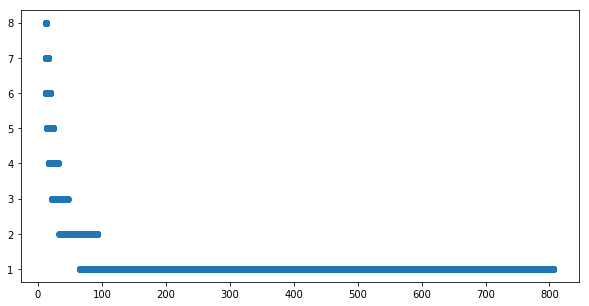

In [135]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter([x['dist'] for x in data['data']],[x['mult'] for x in data['data']])

(array([14800., 14839.,  9070.,  7704.,  6642.,  3782.,  3800.,  3765.,
         3881.,  3468.,  1942.,  1975.,  1948.,  1916.,  1887.,  1912.,
         1886.,  1841.,  1847.,  1782.]),
 array([ 12.50918543,  52.17472666,  91.84026788, 131.50580911,
        171.17135034, 210.83689157, 250.5024328 , 290.16797402,
        329.83351525, 369.49905648, 409.16459771, 448.83013894,
        488.49568016, 528.16122139, 567.82676262, 607.49230385,
        647.15784508, 686.8233863 , 726.48892753, 766.15446876,
        805.82000999]),
 <a list of 20 Patch objects>)

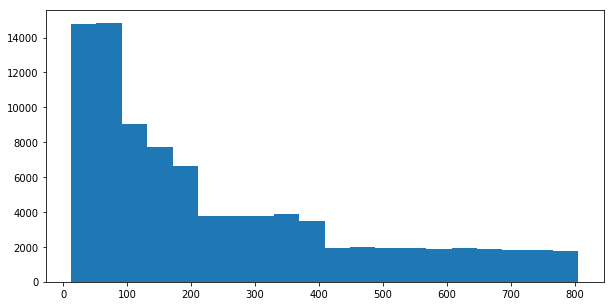

In [137]:
plt.hist([x['dist'] for x in data['data']], bins=20)